
<div style="padding:16px;border-radius:16px;background:linear-gradient(90deg,#0ea5e9,#a78bfa,#22c55e);color:white;">
  <h1 style="margin:0;">ANN Model as a Classifier</h1>
  <p style="margin:8px 0 0 0;font-size:15px;">OR &amp; XOR gates • Activations • Logits→Probabilities • Optimizers • Losses (teaching notebook)</p>
</div>

<div style="margin-top:14px;padding:12px;border-radius:14px;background:#0b1220;color:#e5e7eb;">
<b style="color:#93c5fd;">You will learn</b>
<ul>
  <li><span style="color:#fca5a5;">Activation functions</span> (sigmoid, tanh, ReLU, softmax) and how their outputs differ</li>
  <li><span style="color:#fdba74;">Logits</span> vs <span style="color:#86efac;">probabilities</span>, and how sigmoid/softmax convert logits → probabilities</li>
  <li><span style="color:#c4b5fd;">Optimizers</span> (full-batch Gradient Descent, Stochastic GD, Adam) and convergence behavior</li>
  <li><span style="color:#f9a8d4;">Losses</span> (MSE, MAE, BCE, CCE, hinge) and how they penalize good/bad predictions</li>
</ul>
</div>

<hr/>

<span style="color:#64748b;">Tip:</span> This notebook is intentionally split into many **small cells** so learners can run them one-by-one and immediately see outputs.



## 0) Setup
<span style="color:#64748b;">Imports, reproducibility, and plotting helpers.</span>


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Reproducibility (important when comparing activations/optimizers)
SEED = 7
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
# Pretty print helpers
def as_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.array(x)

def accuracy_from_probs(p, y_true, threshold=0.5):
    p = as_np(p).reshape(-1)
    y_true = as_np(y_true).reshape(-1)
    y_hat = (p >= threshold).astype(int)
    return (y_hat == y_true.astype(int)).mean()

In [3]:
# 2D decision boundary plotter for gate data
def plot_decision_boundary_binary(model, X, y, title, prob_fn, grid_pad=0.6, steps=200):
    Xnp = as_np(X)
    xmin, xmax = Xnp[:,0].min()-grid_pad, Xnp[:,0].max()+grid_pad
    ymin, ymax = Xnp[:,1].min()-grid_pad, Xnp[:,1].max()+grid_pad

    xs = np.linspace(xmin, xmax, steps)
    ys = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(xs, ys)
    grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)

    with torch.no_grad():
        logits = model(torch.tensor(grid, device=device))
        probs = prob_fn(logits).detach().cpu().numpy().reshape(-1)

    zz = probs.reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, zz, levels=30)
    plt.colorbar(label='P(class=1)')
    # points
    for cls, marker in [(0,'o'),(1,'x')]:
        mask = (as_np(y).reshape(-1) == cls)
        plt.scatter(Xnp[mask,0], Xnp[mask,1], marker=marker)
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()


## 1) Datasets: OR and XOR (tiny but perfect for learning)
We will reuse the *same points* but change labels.


In [5]:
X = torch.tensor([[0.,0.],
                  [0.,1.],
                  [1.,0.],
                  [1.,1.]], device=device)

y_or  = torch.tensor([[0.],[1.],[1.],[1.]], device=device)
y_xor = torch.tensor([[0.],[1.],[1.],[0.]], device=device)

print('X:', X)
print('y_or:', y_or.T)
print('y_xor:', y_xor.T)

X: tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]], device='cuda:0')
y_or: tensor([[0., 1., 1., 1.]], device='cuda:0')
y_xor: tensor([[0., 1., 1., 0.]], device='cuda:0')


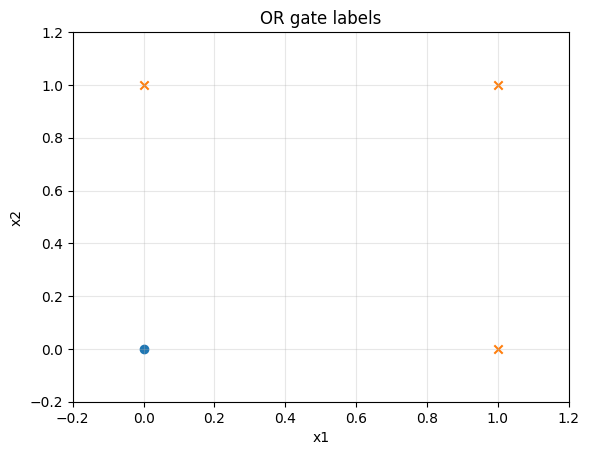

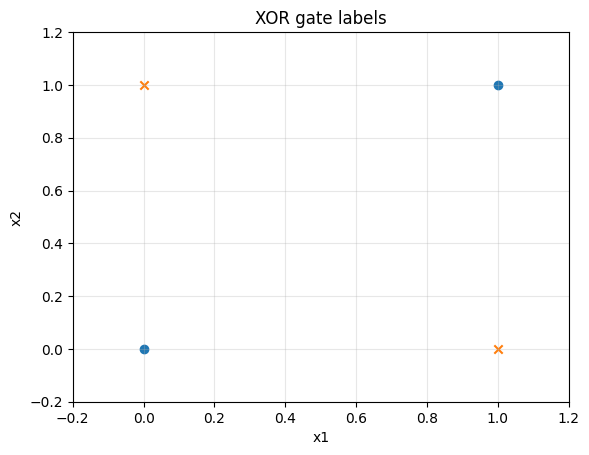

In [6]:
# Visualize the points with their labels

def plot_gate_points(X, y, title):
    Xnp = as_np(X)
    ynp = as_np(y).reshape(-1)
    plt.figure()
    for cls, marker in [(0,'o'),(1,'x')]:
        mask = (ynp == cls)
        plt.scatter(Xnp[mask,0], Xnp[mask,1], marker=marker)
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(-0.2,1.2)
    plt.ylim(-0.2,1.2)
    plt.grid(True, alpha=0.3)
    plt.show()

plot_gate_points(X, y_or,  'OR gate labels')
plot_gate_points(X, y_xor, 'XOR gate labels')


## 2) Activation functions: visuals + outputs
We’ll show the curve and the output values for a few example logits.


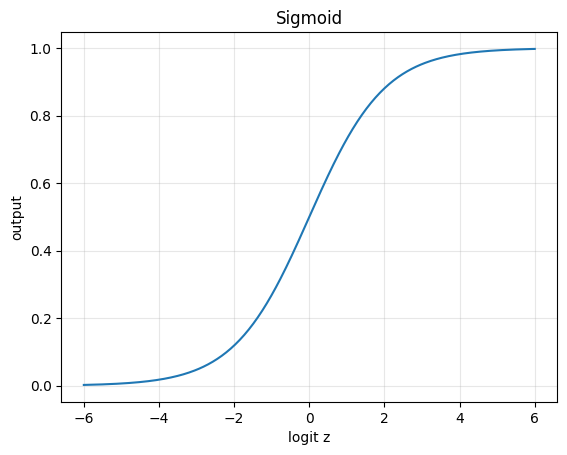

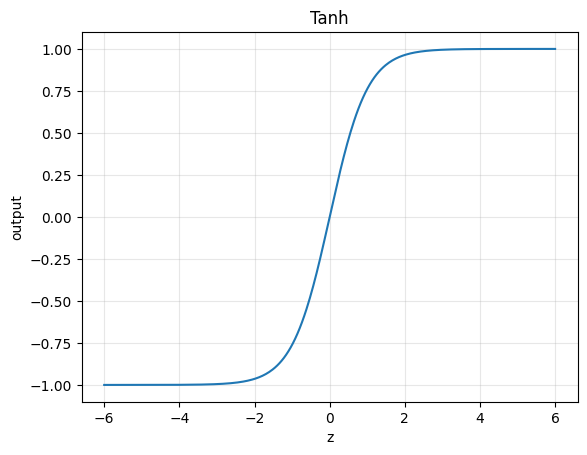

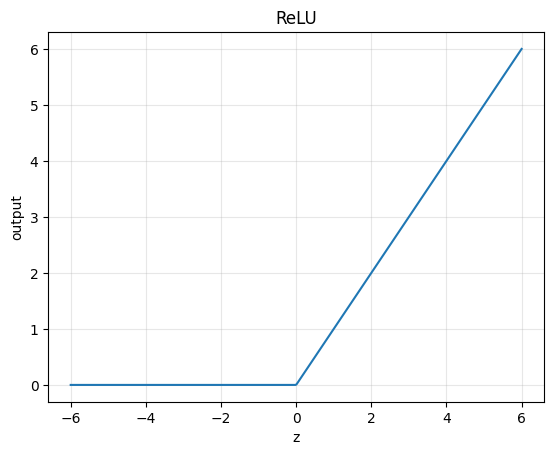

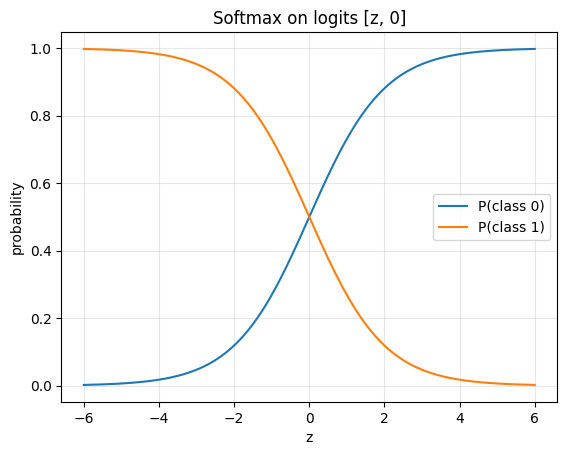

Sample logits: [-6 -2  0  2  6]
sigmoid: [0.0025 0.1192 0.5    0.8808 0.9975]
tanh   : [-1.    -0.964  0.     0.964  1.   ]
relu   : [0 0 0 2 6]
softmax([z,0]) class1 probs: [0.9975 0.8808 0.5    0.1192 0.0025]


In [7]:
# Activation functions (numpy versions for plotting)

def sigmoid_np(z):
    return 1/(1+np.exp(-z))

def tanh_np(z):
    return np.tanh(z)

def relu_np(z):
    return np.maximum(0,z)

def softmax_np(z):
    z = np.array(z)
    z = z - z.max(axis=-1, keepdims=True)
    e = np.exp(z)
    return e / e.sum(axis=-1, keepdims=True)

z = np.linspace(-6,6,400)

plt.figure(); plt.plot(z, sigmoid_np(z)); plt.title('Sigmoid'); plt.xlabel('logit z'); plt.ylabel('output'); plt.grid(True, alpha=0.3); plt.show()
plt.figure(); plt.plot(z, tanh_np(z));    plt.title('Tanh');    plt.xlabel('z'); plt.ylabel('output'); plt.grid(True, alpha=0.3); plt.show()
plt.figure(); plt.plot(z, relu_np(z));    plt.title('ReLU');    plt.xlabel('z'); plt.ylabel('output'); plt.grid(True, alpha=0.3); plt.show()

# Softmax is vector-valued, so we show it on 2-class logits [z, 0]
z2 = np.stack([z, np.zeros_like(z)], axis=1)
sm = softmax_np(z2)
plt.figure(); plt.plot(z, sm[:,0], label='P(class 0)'); plt.plot(z, sm[:,1], label='P(class 1)');
plt.title('Softmax on logits [z, 0]'); plt.xlabel('z'); plt.ylabel('probability'); plt.legend(); plt.grid(True, alpha=0.3); plt.show()

sample_logits = np.array([-6,-2,0,2,6])
print('Sample logits:', sample_logits)
print('sigmoid:', np.round(sigmoid_np(sample_logits), 4))
print('tanh   :', np.round(tanh_np(sample_logits), 4))
print('relu   :', np.round(relu_np(sample_logits), 4))
print('softmax([z,0]) class1 probs:', np.round(softmax_np(np.stack([sample_logits, np.zeros_like(sample_logits)], axis=1))[:,1], 4))


## 3) Tiny ANN classifier (PyTorch)
We’ll use a minimal **MLP** with a configurable activation for the hidden layer.

- For binary models we output **one logit** (raw score).
- For softmax models we output **two logits** (one per class).


In [8]:
# Map activation names to torch modules

def activation_module(name: str):
    name = name.lower()
    if name == 'sigmoid':
        return nn.Sigmoid()
    if name == 'tanh':
        return nn.Tanh()
    if name == 'relu':
        return nn.ReLU()
    raise ValueError(f'Unknown activation: {name}')


class BinaryMLP(nn.Module):
    # 2 -> hidden -> 1 (logit output)
    def __init__(self, hidden=4, activation='relu'):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            activation_module(activation),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x)

class SoftmaxMLP(nn.Module):
    # 2 -> hidden -> 2 (two logits)
    def __init__(self, hidden=4, activation='relu'):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            activation_module(activation),
            nn.Linear(hidden, 2)
        )
    def forward(self, x):
        return self.net(x)

In [9]:
def train_binary(model, X, y, loss_name='bce', optimizer_name='adam', lr=0.1, epochs=2000, batch_size=None, verbose=False):
    model = model.to(device)
    Xd, yd = X.to(device), y.to(device)

    # Loss choices (binary)
    loss_name = loss_name.lower()
    if loss_name == 'bce':
        criterion = nn.BCEWithLogitsLoss()
        # model outputs logits; criterion applies sigmoid internally
        prob_fn = torch.sigmoid
    elif loss_name == 'mse':
        criterion = nn.MSELoss()
        prob_fn = torch.sigmoid
    elif loss_name == 'mae':
        criterion = nn.L1Loss()
        prob_fn = torch.sigmoid
    elif loss_name == 'hinge':
        # We'll implement hinge on logits with y in {-1,+1}
        criterion = None
        prob_fn = torch.sigmoid
    else:
        raise ValueError('loss_name must be one of: bce, mse, mae, hinge')

    # Optimizer
    optimizer_name = optimizer_name.lower()
    if optimizer_name in ['gd','sgd']:
        opt = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'adam':
        opt = optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError('optimizer_name must be one of: gd, sgd, adam')

    if batch_size is None:
        batch_size = len(Xd)

    losses = []
    for epoch in range(epochs):
        # mini-batch sampling
        idx = torch.randperm(len(Xd))
        for start in range(0, len(Xd), batch_size):
            b = idx[start:start+batch_size]
            xb, yb = Xd[b], yd[b]

            opt.zero_grad()
            logits = model(xb)

            if loss_name == 'hinge':
                y_pm = yb*2 - 1  # 0/1 -> -1/+1
                loss = torch.clamp(1 - y_pm*logits, min=0).mean()
            elif loss_name in ['mse','mae']:
                probs = torch.sigmoid(logits)
                loss = criterion(probs, yb)
            else:
                loss = criterion(logits, yb)

            loss.backward()
            opt.step()

        losses.append(float(loss.detach().cpu()))

        if verbose and (epoch % (epochs//10) == 0):
            print(f'epoch {epoch:4d} loss={losses[-1]:.4f}')

    with torch.no_grad():
        logits_all = model(Xd)
        probs_all = prob_fn(logits_all)
        acc = accuracy_from_probs(probs_all, yd)

    return {
        'model': model,
        'losses': losses,
        'logits': logits_all.detach().cpu(),
        'probs': probs_all.detach().cpu(),
        'acc': acc,
        'prob_fn': prob_fn
    }

In [10]:
def train_softmax(model, X, y01, optimizer_name='adam', lr=0.1, epochs=2000, batch_size=None, verbose=False):
    model = model.to(device)
    Xd = X.to(device)
    y = y01.reshape(-1).long().to(device)  # class index 0/1

    criterion = nn.CrossEntropyLoss()  # expects logits [N,2]

    optimizer_name = optimizer_name.lower()
    if optimizer_name in ['gd','sgd']:
        opt = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'adam':
        opt = optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError('optimizer_name must be one of: gd, sgd, adam')

    if batch_size is None:
        batch_size = len(Xd)

    losses = []
    for epoch in range(epochs):
        idx = torch.randperm(len(Xd))
        for start in range(0, len(Xd), batch_size):
            b = idx[start:start+batch_size]
            xb, yb = Xd[b], y[b]

            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()

        losses.append(float(loss.detach().cpu()))
        if verbose and (epoch % (epochs//10) == 0):
            print(f'epoch {epoch:4d} loss={losses[-1]:.4f}')

    with torch.no_grad():
        logits_all = model(Xd)
        probs_all = torch.softmax(logits_all, dim=1)
        pred = probs_all.argmax(dim=1)
        acc = float((pred == y).float().mean().cpu())

    return {
        'model': model,
        'losses': losses,
        'logits': logits_all.detach().cpu(),
        'probs': probs_all.detach().cpu(),
        'acc': acc
    }



## 4) Activation comparison (one cell per activation)
We keep **optimizer fixed = Adam** so we can focus on activation behavior.

<span style="color:#64748b;">Run each cell independently and observe:</span>
- Loss curve
- Predicted probabilities
- Decision boundary for OR and XOR


### 4.1 Sigmoid (hidden activation)
<span style="color:#64748b;">Hidden activation = sigmoid, output = logit (probability via sigmoid)</span>


Sigmoid hidden | OR  acc: 1.0
Sigmoid hidden | XOR acc: 1.0


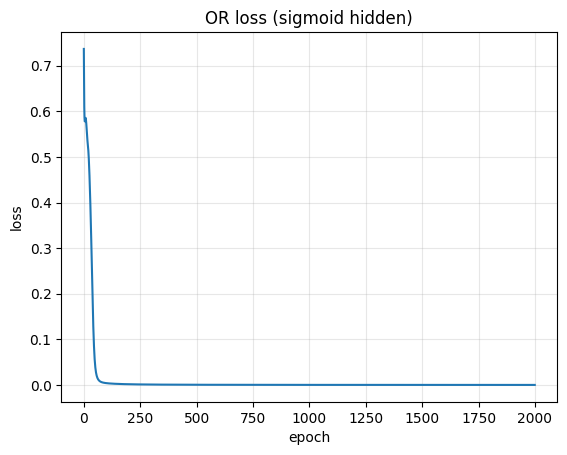

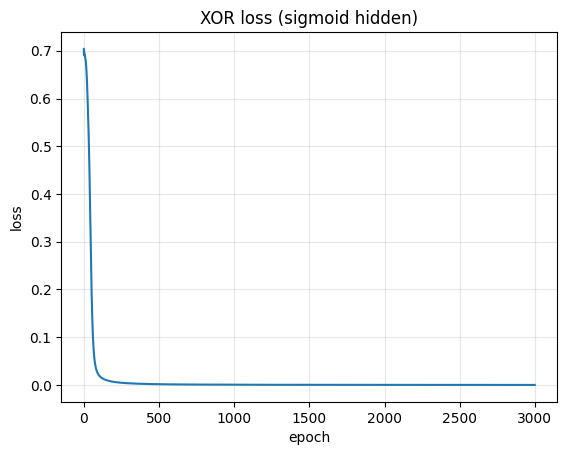

OR  probs: [1.e-04 1.e+00 1.e+00 1.e+00]
XOR probs: [0.000e+00 1.000e+00 9.999e-01 1.000e-04]


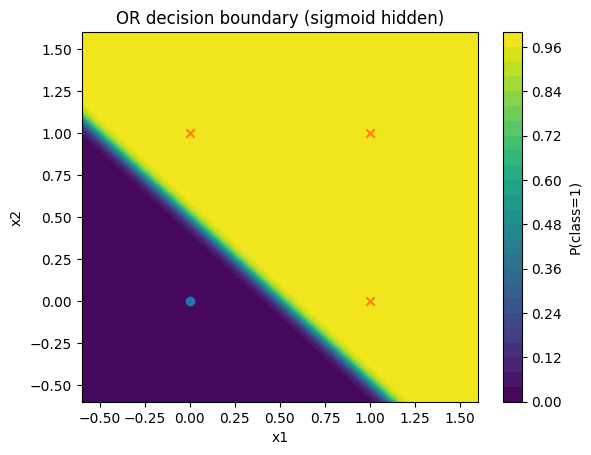

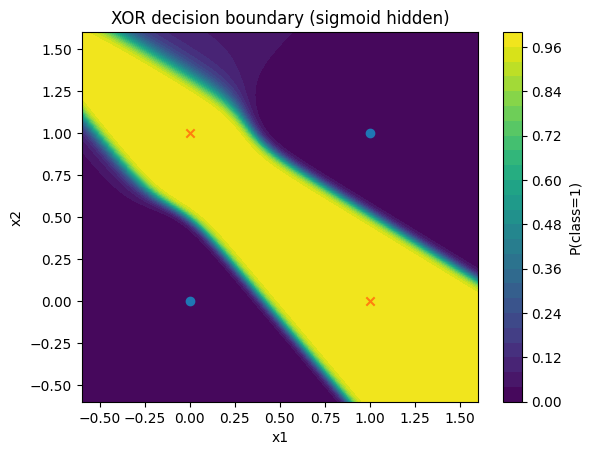

In [11]:
# SIGMOID activation demo
model_or  = BinaryMLP(hidden=4, activation='sigmoid')
res_or    = train_binary(model_or, X, y_or,  loss_name='bce', optimizer_name='adam', lr=0.1, epochs=2000)

model_xor = BinaryMLP(hidden=4, activation='sigmoid')
res_xor   = train_binary(model_xor, X, y_xor, loss_name='bce', optimizer_name='adam', lr=0.1, epochs=3000)

print('Sigmoid hidden | OR  acc:', res_or['acc'])
print('Sigmoid hidden | XOR acc:', res_xor['acc'])

plt.figure(); plt.plot(res_or['losses']); plt.title('OR loss (sigmoid hidden)'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()
plt.figure(); plt.plot(res_xor['losses']); plt.title('XOR loss (sigmoid hidden)'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()

print('OR  probs:', np.round(as_np(res_or['probs']).reshape(-1), 4))
print('XOR probs:', np.round(as_np(res_xor['probs']).reshape(-1), 4))

plot_decision_boundary_binary(res_or['model'], X, y_or,  'OR decision boundary (sigmoid hidden)',  prob_fn=torch.sigmoid)
plot_decision_boundary_binary(res_xor['model'], X, y_xor, 'XOR decision boundary (sigmoid hidden)', prob_fn=torch.sigmoid)


### 4.2 Tanh (hidden activation)
<span style="color:#64748b;">Hidden activation = tanh, output = logit (probability via sigmoid)</span>


Tanh hidden | OR  acc: 1.0
Tanh hidden | XOR acc: 1.0


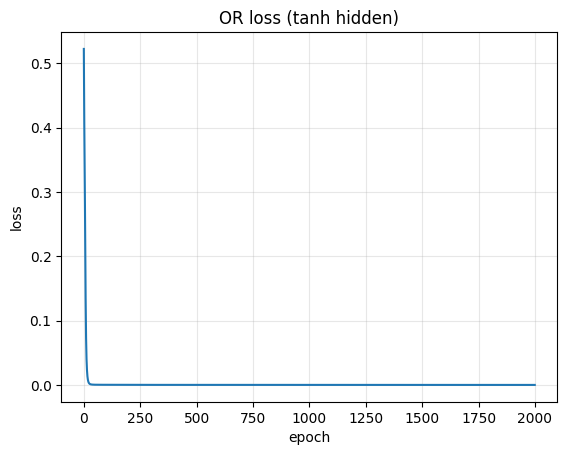

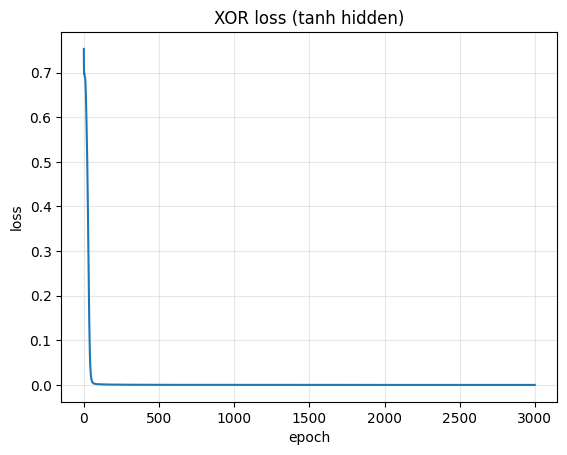

OR  probs: [0. 1. 1. 1.]
XOR probs: [0. 1. 1. 0.]


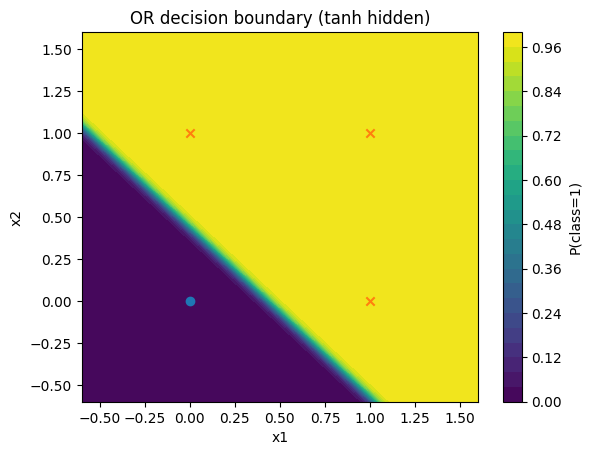

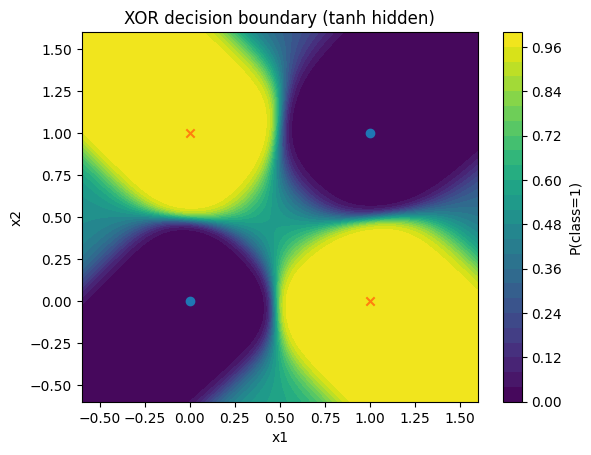

In [12]:
# TANH activation demo
model_or  = BinaryMLP(hidden=4, activation='tanh')
res_or    = train_binary(model_or, X, y_or,  loss_name='bce', optimizer_name='adam', lr=0.1, epochs=2000)

model_xor = BinaryMLP(hidden=4, activation='tanh')
res_xor   = train_binary(model_xor, X, y_xor, loss_name='bce', optimizer_name='adam', lr=0.1, epochs=3000)

print('Tanh hidden | OR  acc:', res_or['acc'])
print('Tanh hidden | XOR acc:', res_xor['acc'])

plt.figure(); plt.plot(res_or['losses']); plt.title('OR loss (tanh hidden)'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()
plt.figure(); plt.plot(res_xor['losses']); plt.title('XOR loss (tanh hidden)'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()

print('OR  probs:', np.round(as_np(res_or['probs']).reshape(-1), 4))
print('XOR probs:', np.round(as_np(res_xor['probs']).reshape(-1), 4))

plot_decision_boundary_binary(res_or['model'], X, y_or,  'OR decision boundary (tanh hidden)',  prob_fn=torch.sigmoid)
plot_decision_boundary_binary(res_xor['model'], X, y_xor, 'XOR decision boundary (tanh hidden)', prob_fn=torch.sigmoid)


### 4.3 ReLU (hidden activation)
<span style="color:#64748b;">Hidden activation = ReLU, output = logit (probability via sigmoid)</span>


ReLU hidden | OR  acc: 1.0
ReLU hidden | XOR acc: 1.0


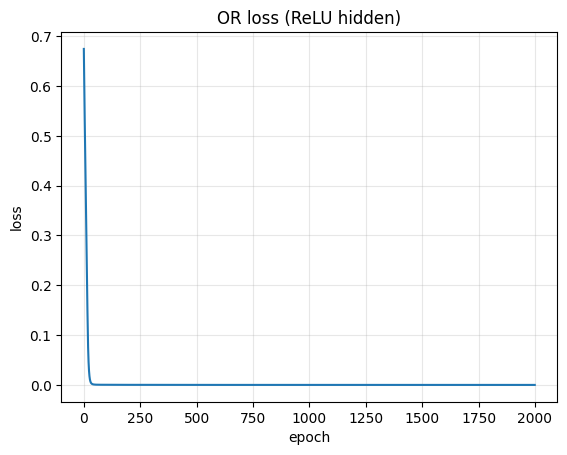

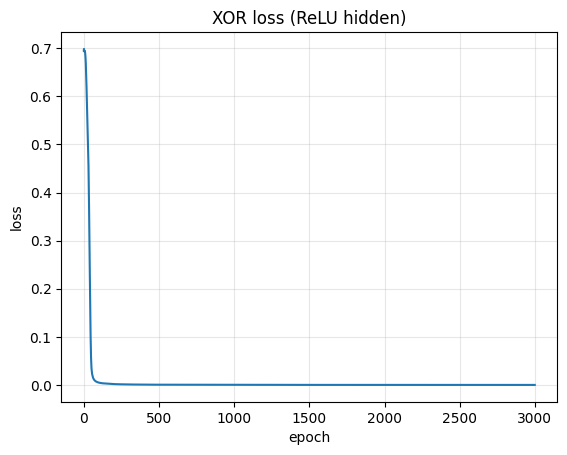

OR  probs: [0. 1. 1. 1.]
XOR probs: [0. 1. 1. 0.]


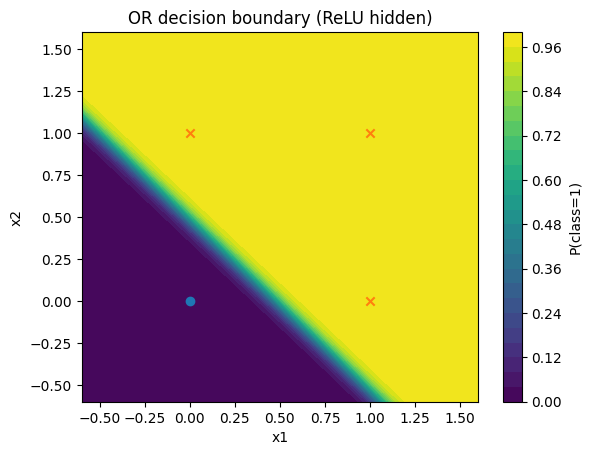

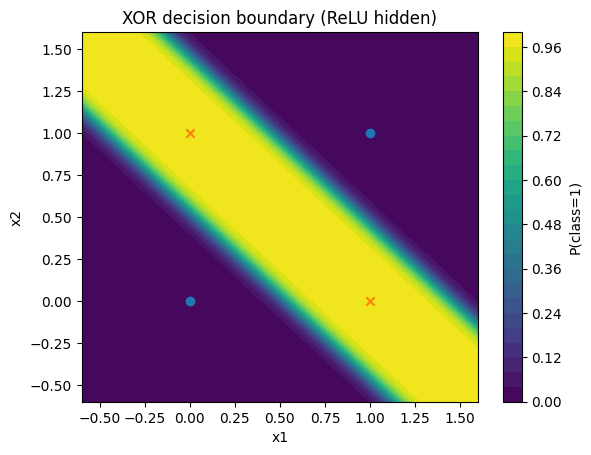

In [13]:
# RELU activation demo
model_or  = BinaryMLP(hidden=4, activation='relu')
res_or    = train_binary(model_or, X, y_or,  loss_name='bce', optimizer_name='adam', lr=0.1, epochs=2000)

model_xor = BinaryMLP(hidden=4, activation='relu')
res_xor   = train_binary(model_xor, X, y_xor, loss_name='bce', optimizer_name='adam', lr=0.1, epochs=3000)

print('ReLU hidden | OR  acc:', res_or['acc'])
print('ReLU hidden | XOR acc:', res_xor['acc'])

plt.figure(); plt.plot(res_or['losses']); plt.title('OR loss (ReLU hidden)'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()
plt.figure(); plt.plot(res_xor['losses']); plt.title('XOR loss (ReLU hidden)'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()

print('OR  probs:', np.round(as_np(res_or['probs']).reshape(-1), 4))
print('XOR probs:', np.round(as_np(res_xor['probs']).reshape(-1), 4))

plot_decision_boundary_binary(res_or['model'], X, y_or,  'OR decision boundary (ReLU hidden)',  prob_fn=torch.sigmoid)
plot_decision_boundary_binary(res_xor['model'], X, y_xor, 'XOR decision boundary (ReLU hidden)', prob_fn=torch.sigmoid)


### 4.4 Softmax (output activation)
<span style="color:#64748b;">Here the model outputs <b>two logits</b> and we apply <b>softmax</b> to get class probabilities.</span>


In [14]:
# SOFTMAX output demo (2 logits -> softmax probabilities)
# We can choose any hidden activation; ReLU is a common default.
model_or  = SoftmaxMLP(hidden=4, activation='relu')
res_or    = train_softmax(model_or, X, y_or,  optimizer_name='adam', lr=0.1, epochs=2000)

model_xor = SoftmaxMLP(hidden=4, activation='relu')
res_xor   = train_softmax(model_xor, X, y_xor, optimizer_name='adam', lr=0.1, epochs=3000)

print('Softmax output | OR  acc:', res_or['acc'])
print('Softmax output | XOR acc:', res_xor['acc'])

plt.figure(); plt.plot(res_or['losses']); plt.title('OR loss (softmax output)'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()
plt.figure(); plt.plot(res_xor['losses']); plt.title('XOR loss (softmax output)'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()

print('OR  probs [P0,P1] per point:
', np.round(as_np(res_or['probs']), 4))
print('XOR probs [P0,P1] per point:
', np.round(as_np(res_xor['probs']), 4))

# Decision boundary: use P(class=1)
prob_fn_softmax_class1 = lambda logits: torch.softmax(logits, dim=1)[:,1:2]
plot_decision_boundary_binary(res_or['model'], X, y_or,  'OR decision boundary (softmax output)',  prob_fn=prob_fn_softmax_class1)
plot_decision_boundary_binary(res_xor['model'], X, y_xor, 'XOR decision boundary (softmax output)', prob_fn=prob_fn_softmax_class1)


SyntaxError: unterminated string literal (detected at line 15) (1986086867.py, line 15)


## 5) Optimizers: Gradient Descent vs Stochastic GD vs Adam
We keep the **activation fixed = ReLU** (common choice) and compare optimizer behaviors.

We’ll interpret:
- **GD** = full-batch update (batch_size = 4)
- **SGD** = stochastic update (batch_size = 1)
- **Adam** = adaptive optimizer


In [16]:
def run_optimizer_demo(dataset='xor', optimizer='gd', lr=0.1, epochs=2000):
    y = y_xor if dataset.lower() == 'xor' else y_or
    batch_size = len(X) if optimizer.lower() == 'gd' else 1

    model = BinaryMLP(hidden=4, activation='relu')
    res = train_binary(
        model, X, y,
        loss_name='bce',
        optimizer_name=('sgd' if optimizer.lower() in ['gd','sgd'] else 'adam'),
        lr=lr,
        epochs=epochs,
        batch_size=batch_size
    )
    title = f"{dataset.upper()} | optimizer={optimizer.upper()} | lr={lr} | acc={res['acc']:.2f}"

    print(title)
    print('probs:', np.round(as_np(res['probs']).reshape(-1), 4))
    plt.figure(); plt.plot(res['losses']); plt.title(title); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()
    plot_decision_boundary_binary(res['model'], X, y, f"Decision boundary: {title}", prob_fn=torch.sigmoid)

    return res

### 5.1 Full-batch Gradient Descent (GD)


XOR | optimizer=GD | lr=0.2 | acc=1.00
probs: [5.00e-04 9.99e-01 9.99e-01 8.90e-03]


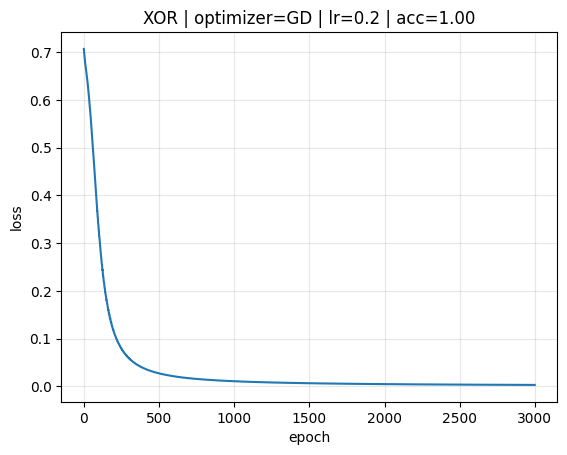

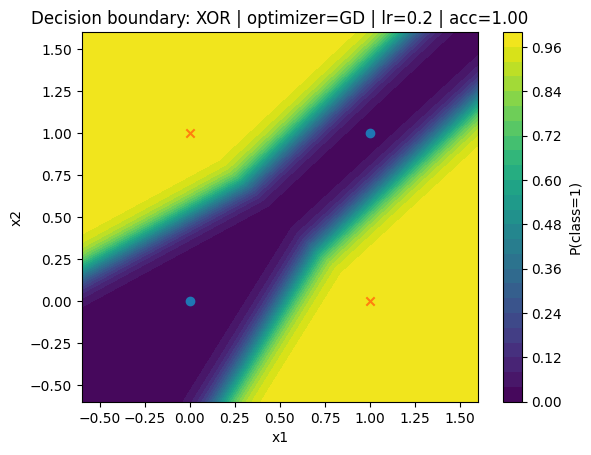

In [17]:
res_gd_xor = run_optimizer_demo(dataset='xor', optimizer='gd', lr=0.2, epochs=3000)

### 5.2 Stochastic Gradient Descent (SGD)


XOR | optimizer=SGD | lr=0.2 | acc=1.00
probs: [2.000e-04 9.997e-01 9.997e-01 2.000e-04]


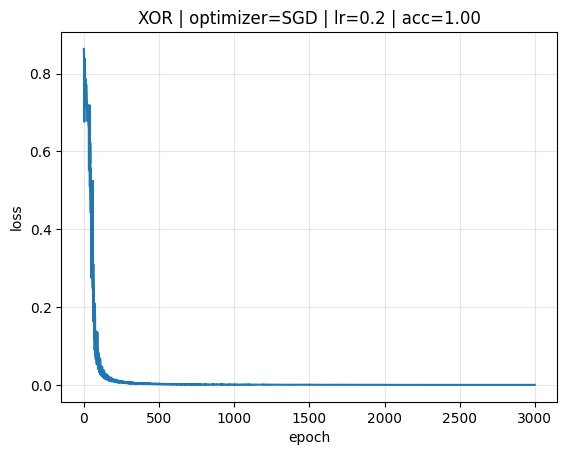

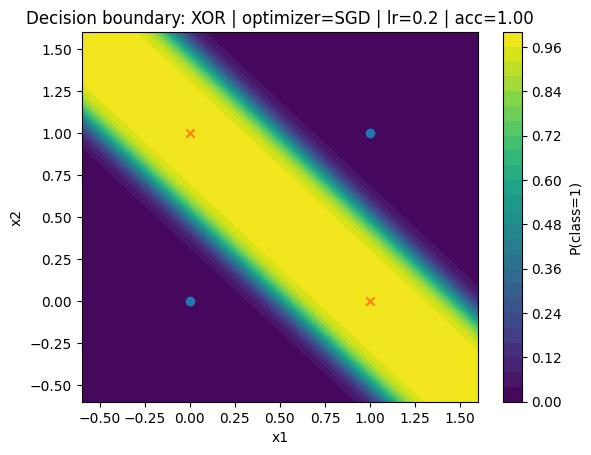

In [18]:

res_sgd_xor = run_optimizer_demo(dataset='xor', optimizer='sgd', lr=0.2, epochs=3000)


### 5.3 Adam


XOR | optimizer=ADAM | lr=0.1 | acc=1.00
probs: [0. 1. 1. 0.]


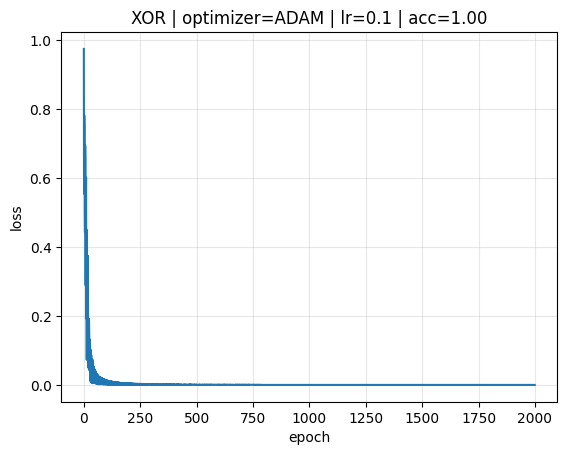

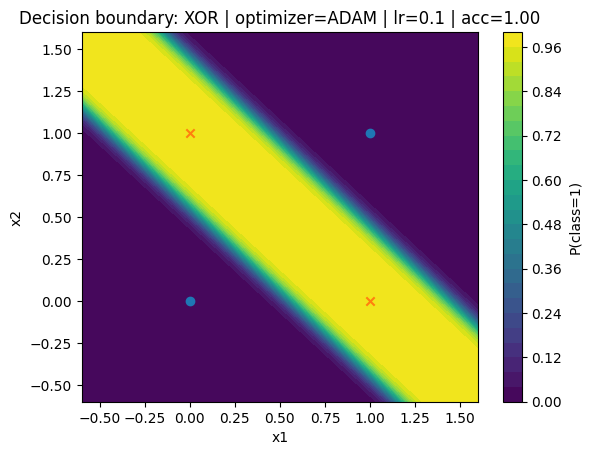

In [19]:

res_adam_xor = run_optimizer_demo(dataset='xor', optimizer='adam', lr=0.1, epochs=2000)


### 5.4 Quick comparison table


In [20]:
import pandas as pd

def last(x):
    return float(x['losses'][-1])

df = pd.DataFrame([
    {'optimizer':'GD (full-batch)', 'final_loss': last(res_gd_xor),   'acc': res_gd_xor['acc']},
    {'optimizer':'SGD (batch=1)',   'final_loss': last(res_sgd_xor),  'acc': res_sgd_xor['acc']},
    {'optimizer':'Adam',            'final_loss': last(res_adam_xor), 'acc': res_adam_xor['acc']},
])
df


,optimizer,final_loss,acc
0,GD (full-batch),2.820952e-03,1.0
1,SGD (batch=1),2.797003e-04,1.0
2,Adam,9.536743e-07,1.0



## 6) What are logits? How sigmoid / softmax turn logits into probabilities
**Logit** = raw score output by the network *before* applying a probability function.

- For binary classification: probability = **sigmoid(logit)**
- For multi-class: probabilities = **softmax(logit_vector)**


In [23]:
# Example logits
logits = torch.tensor([-6., -2., 0., 2., 6.])
probs_sigmoid = torch.sigmoid(logits)

print('Binary case:')
print('logits :', logits.numpy())
print('sigmoid:', probs_sigmoid.numpy())

# Softmax example: 2-class logits
logits2 = torch.stack([logits, torch.zeros_like(logits)], dim=1)  # [N,2]
probs_softmax = torch.softmax(logits2, dim=1)

print('Softmax case (2 classes): logits [z,0]')
print('probs:', probs_softmax.numpy())


Binary case:
logits : [-6. -2.  0.  2.  6.]
sigmoid: [0.00247262 0.11920292 0.5        0.880797   0.9975274 ]
Softmax case (2 classes): logits [z,0]
probs: [[0.00247262 0.9975274 ]
 [0.11920291 0.880797  ]
 [0.5        0.5       ]
 [0.880797   0.11920291]
 [0.9975274  0.00247262]]


In [24]:
# Show logits/probs produced by a trained model on XOR
model = BinaryMLP(hidden=4, activation='relu')
res = train_binary(model, X, y_xor, loss_name='bce', optimizer_name='adam', lr=0.1, epochs=2000)

print('XOR logits:', np.round(as_np(res['logits']).reshape(-1), 4))
print('XOR probs :', np.round(as_np(res['probs']).reshape(-1), 4))
print('XOR acc   :', res['acc'])


XOR logits: [-0. -0. -0. -0.]
XOR probs : [0.5 0.5 0.5 0.5]
XOR acc   : 0.5



## 7) Loss functions: how they behave
We’ll visualize each loss as a function of the predicted probability (or margin) so learners can **see** differences.

We’ll show:
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- Binary Cross Entropy (BCE)
- Categorical Cross Entropy (CCE)
- Hinge loss


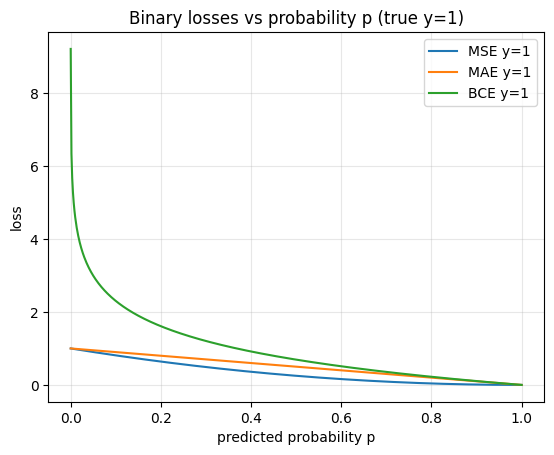

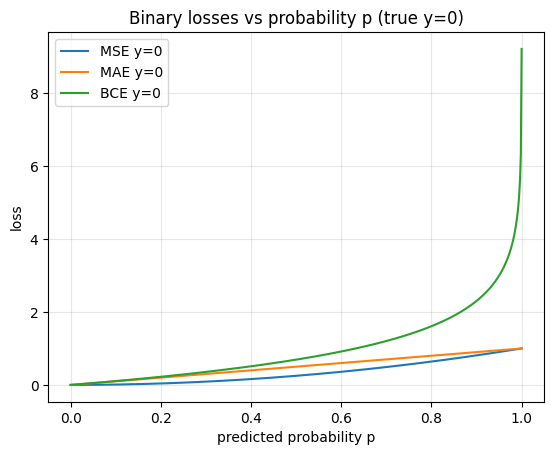

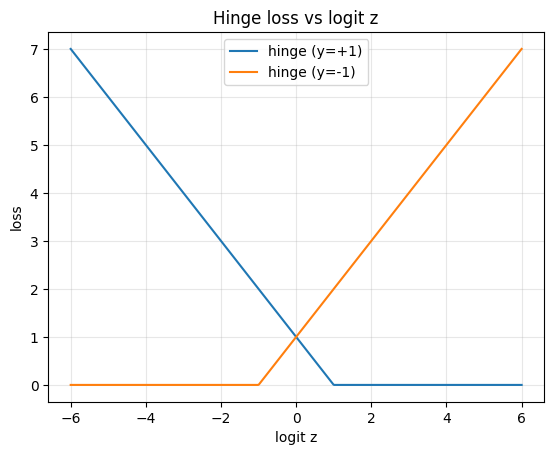

In [25]:
# Loss curves for a *binary* label y ∈ {0,1} as a function of predicted probability p
p = np.linspace(1e-4, 1-1e-4, 600)

def mse(p, y):
    return (p - y)**2

def mae(p, y):
    return np.abs(p - y)

def bce(p, y):
    return -(y*np.log(p) + (1-y)*np.log(1-p))

# Hinge is usually defined on margins with y in {-1,+1}. We'll plot hinge in terms of logit z.
z = np.linspace(-6, 6, 600)

def hinge_from_logit(z, y_pm):
    return np.maximum(0, 1 - y_pm*z)

plt.figure();
plt.plot(p, mse(p,1), label='MSE y=1');
plt.plot(p, mae(p,1), label='MAE y=1');
plt.plot(p, bce(p,1), label='BCE y=1');
plt.title('Binary losses vs probability p (true y=1)');
plt.xlabel('predicted probability p');
plt.ylabel('loss');
plt.legend();
plt.grid(True, alpha=0.3);
plt.show()

plt.figure();
plt.plot(p, mse(p,0), label='MSE y=0');
plt.plot(p, mae(p,0), label='MAE y=0');
plt.plot(p, bce(p,0), label='BCE y=0');
plt.title('Binary losses vs probability p (true y=0)');
plt.xlabel('predicted probability p');
plt.ylabel('loss');
plt.legend();
plt.grid(True, alpha=0.3);
plt.show()

plt.figure();
plt.plot(z, hinge_from_logit(z, +1), label='hinge (y=+1)');
plt.plot(z, hinge_from_logit(z, -1), label='hinge (y=-1)');
plt.title('Hinge loss vs logit z');
plt.xlabel('logit z');
plt.ylabel('loss');
plt.legend();
plt.grid(True, alpha=0.3);
plt.show()


### 7.1 Apply each loss on the same XOR training task (small independent cells)
We keep the model the same and just switch losses to see training behavior.


#### Loss = MSE
<span style="color:#64748b;">BinaryMLP (ReLU hidden) trained on XOR with MSE.</span>


MSE | acc: 0.75
logits: [-7.5774  0.694   0.694   0.694 ]
probs : [5.000e-04 6.669e-01 6.669e-01 6.669e-01]


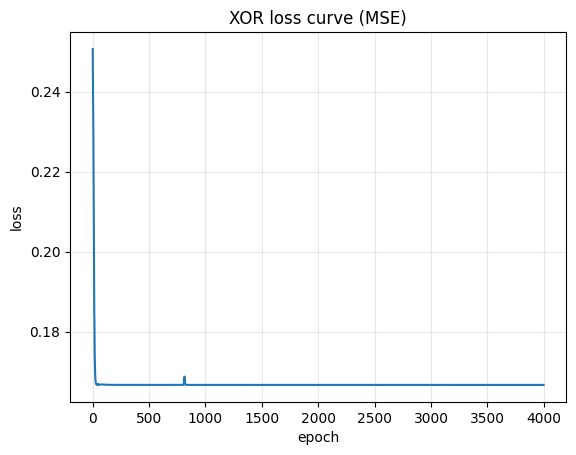

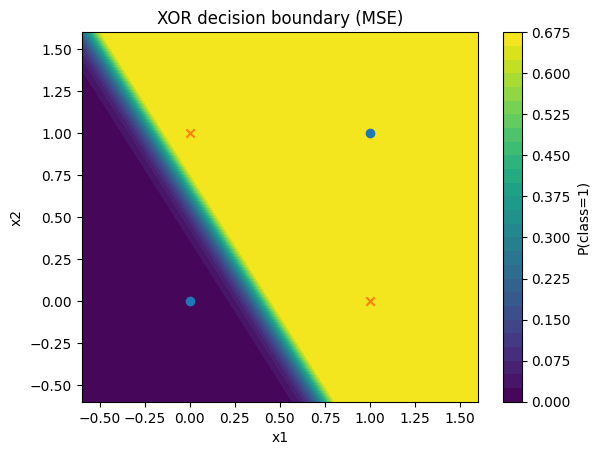

In [26]:
model = BinaryMLP(hidden=4, activation='relu')
res = train_binary(model, X, y_xor, loss_name='mse', optimizer_name='adam', lr=0.1, epochs=4000)
print('MSE | acc:', res['acc'])
print('logits:', np.round(as_np(res['logits']).reshape(-1), 4))
print('probs :', np.round(as_np(res['probs']).reshape(-1), 4))
plt.figure(); plt.plot(res['losses']); plt.title('XOR loss curve (MSE)'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()
plot_decision_boundary_binary(res['model'], X, y_xor, 'XOR decision boundary (MSE)', prob_fn=torch.sigmoid)


#### Loss = MAE
<span style="color:#64748b;">BinaryMLP (ReLU hidden) trained on XOR with MAE.</span>


MAE | acc: 1.0
logits: [-11.7705  13.5913  13.4944 -11.7698]
probs : [0. 1. 1. 0.]


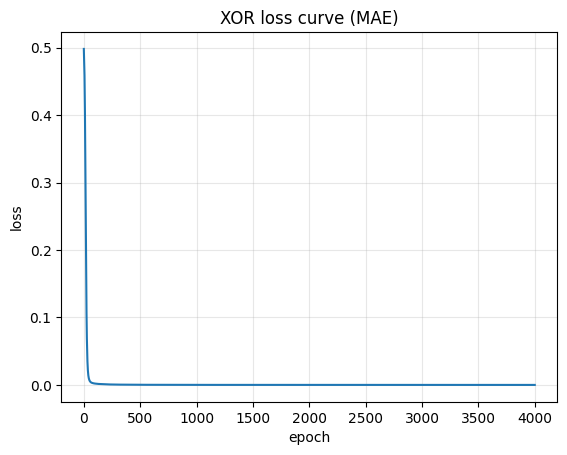

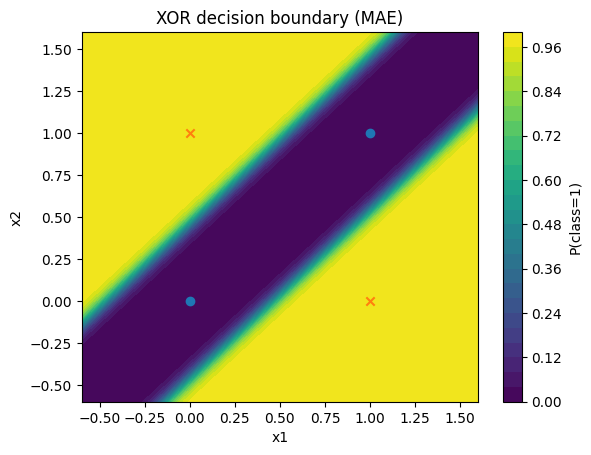

In [27]:
model = BinaryMLP(hidden=4, activation='relu')
res = train_binary(model, X, y_xor, loss_name='mae', optimizer_name='adam', lr=0.1, epochs=4000)
print('MAE | acc:', res['acc'])
print('logits:', np.round(as_np(res['logits']).reshape(-1), 4))
print('probs :', np.round(as_np(res['probs']).reshape(-1), 4))
plt.figure(); plt.plot(res['losses']); plt.title('XOR loss curve (MAE)'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()
plot_decision_boundary_binary(res['model'], X, y_xor, 'XOR decision boundary (MAE)', prob_fn=torch.sigmoid)


#### Loss = BCE
<span style="color:#64748b;">BinaryMLP (ReLU hidden) trained on XOR with BCE.</span>


BCE | acc: 1.0
logits: [-9.1485 12.1135 11.4979 -9.1485]
probs : [1.e-04 1.e+00 1.e+00 1.e-04]


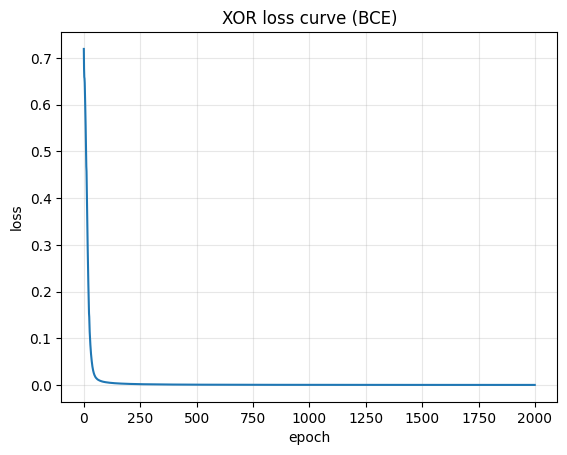

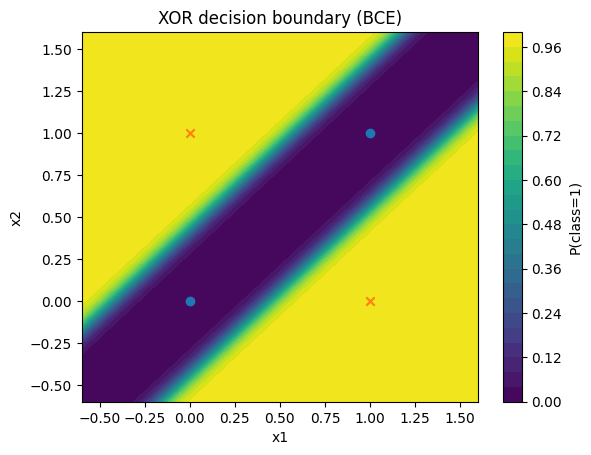

In [28]:
model = BinaryMLP(hidden=4, activation='relu')
res = train_binary(model, X, y_xor, loss_name='bce', optimizer_name='adam', lr=0.1, epochs=2000)
print('BCE | acc:', res['acc'])
print('logits:', np.round(as_np(res['logits']).reshape(-1), 4))
print('probs :', np.round(as_np(res['probs']).reshape(-1), 4))
plt.figure(); plt.plot(res['losses']); plt.title('XOR loss curve (BCE)'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()
plot_decision_boundary_binary(res['model'], X, y_xor, 'XOR decision boundary (BCE)', prob_fn=torch.sigmoid)


#### Loss = HINGE
<span style="color:#64748b;">BinaryMLP (ReLU hidden) trained on XOR with HINGE.</span>


HINGE | acc: 0.75
logits: [-0.9928 -0.9928  1.4228 -0.9928]
probs : [0.2704 0.2704 0.8058 0.2704]


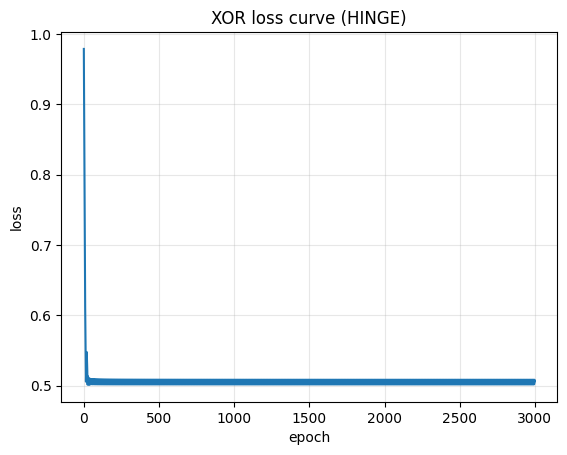

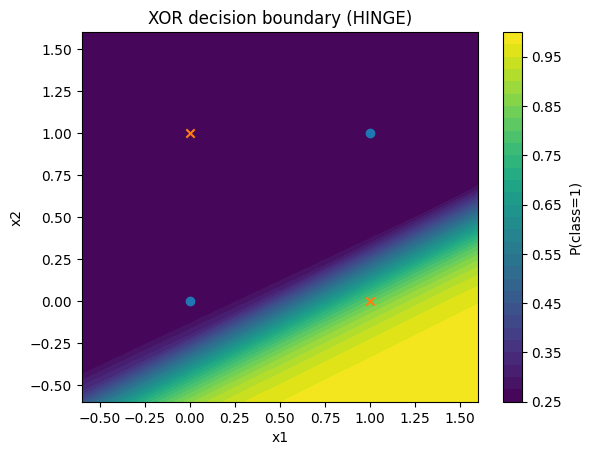

In [29]:
model = BinaryMLP(hidden=4, activation='relu')
res = train_binary(model, X, y_xor, loss_name='hinge', optimizer_name='adam', lr=0.1, epochs=3000)
print('HINGE | acc:', res['acc'])
print('logits:', np.round(as_np(res['logits']).reshape(-1), 4))
print('probs :', np.round(as_np(res['probs']).reshape(-1), 4))
plt.figure(); plt.plot(res['losses']); plt.title('XOR loss curve (HINGE)'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()
plot_decision_boundary_binary(res['model'], X, y_xor, 'XOR decision boundary (HINGE)', prob_fn=torch.sigmoid)


#### Loss = Categorical Cross Entropy (CCE)
<span style="color:#64748b;">SoftmaxMLP outputs 2 logits; CrossEntropyLoss is CCE for multi-class.</span>


CCE | acc: 0.75
logits: [[ 5.5721 -6.6139]
 [-6.4824  5.7102]
 [-0.3388 -0.3388]
 [-0.3388 -0.3388]]
probs : [[1.  0. ]
 [0.  1. ]
 [0.5 0.5]
 [0.5 0.5]]


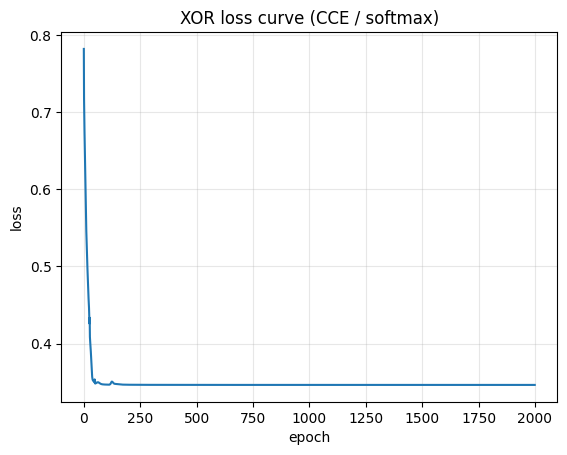

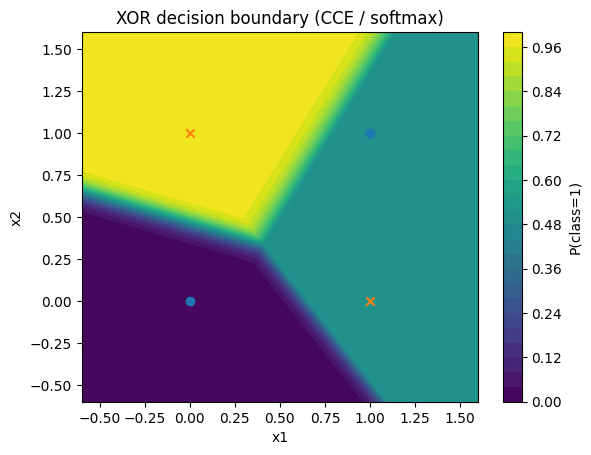

In [31]:
model = SoftmaxMLP(hidden=4, activation='relu')
res = train_softmax(model, X, y_xor, optimizer_name='adam', lr=0.1, epochs=2000)
print('CCE | acc:', res['acc'])
print('logits:', np.round(as_np(res['logits']), 4))
print('probs :', np.round(as_np(res['probs']), 4))
plt.figure(); plt.plot(res['losses']); plt.title('XOR loss curve (CCE / softmax)'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True, alpha=0.3); plt.show()
prob_fn_softmax_class1 = lambda logits: torch.softmax(logits, dim=1)[:,1:2]
plot_decision_boundary_binary(res['model'], X, y_xor, 'XOR decision boundary (CCE / softmax)', prob_fn=prob_fn_softmax_class1)



---

## 8) Wrap-up (what to look for)
- **OR** is linearly separable → even very simple networks do well.
- **XOR** is not linearly separable → you need a hidden layer (non-linearity).
- **Logits** are raw scores; **sigmoid/softmax** convert them to probabilities.
- **BCE/CCE** usually train classifiers more cleanly than MSE/MAE.
- **Adam** often converges faster and more reliably on small problems (but tune learning rate!).

<div style="padding:12px;border-radius:14px;background:#0b1220;color:#e5e7eb;">
<b style="color:#86efac;">Practice idea:</b> Try changing <code>hidden=4</code> to <code>hidden=2</code> or <code>hidden=8</code>, or adjust <code>lr</code> and <code>epochs</code> and see which combinations still solve XOR.
</div>
